# Counting Boats from Space - Part 1

In [39]:
%reload_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv
%matplotlib inline

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


## 1. Import requirements

In [40]:
import os 
import json
import shapely.geometry
import IPython.display
from xcube_sh.cube import open_cube
from xcube_sh.observers import Observers

In [41]:
from src.GIS_utils import bbox_from_point
from src.config import CubeConfig
from src.preprocess import preprocess, plot_cube_and_background, save_labels

In [42]:
data_dir = "/home/jovyan/data" # data directory (path)
RADIUS = 500 # AOI radius in meters

## 2. Specify AOI + time window

In [84]:
##### Restart ports AL, BE, BG, CY, DK, DE, EE, EL, ES + SI, SK, TR, UA, UK + Straits

In [204]:
with open(os.path.join(data_dir, 'aoi.json'), 'r') as f:
    aoi_file = json.load(f)
    coords = aoi_file['NonEUStraits']
    aoi_idx = 5 #### Edit locations
    aoi_name = list(coords.keys())[aoi_idx]
    first_loc = coords[aoi_name][0]
    print(f"first location: {first_loc}")
    lat, lon = coords[aoi_name][0][0], coords[aoi_name][0][1]
    print('{}/{} {}: {}, {}'.format(aoi_idx+1, len(coords), aoi_name, lat, lon))

first location: [45.62, 141.92]
6/6 Tartary: 45.62, 141.92


In [205]:
#import matplotlib.pyplot as plt
#plt.figure(1, figsize=(10,5))
#plt.hist([k[:2] for k in aoi_file['Ports'] if '(' not in k])
#plt.show()

In [206]:
#print(len([k for k in aoi_file['Ports'] if '(' not in k]))

In [207]:
start_date = '2019-01-01'
end_date = '2019-06-01'

In [208]:
bbox = bbox_from_point(lat=lat, lon=lon, r=RADIUS) # WGS84 coordinates
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

## 3. Load the data in a cube

In [209]:
cube_config = CubeConfig(dataset_name='S2L1C',
                         band_names=['B03', 'B08', 'CLP'], # GREEN + NIR + Clouds
                         tile_size=[2*RADIUS//10, 2*RADIUS//10],
                         geometry=bbox,
                         time_range=[start_date, end_date],
                         time_period='5D', ##### Set to 1 day
                        )

In [210]:
cube_config

In [211]:
request_collector = Observers.request_collector()
#request_collector.stats # statistics for SentinelHub request

In [212]:
cube = open_cube(cube_config, observer=request_collector)
#cube # Verify the content of the cube

In [213]:
#type(cube)

In [214]:
#cube

## 4. Preprocess Cube

Keeping 31/31 images without nans
Keeping 15/31 images 80.0% cloudless


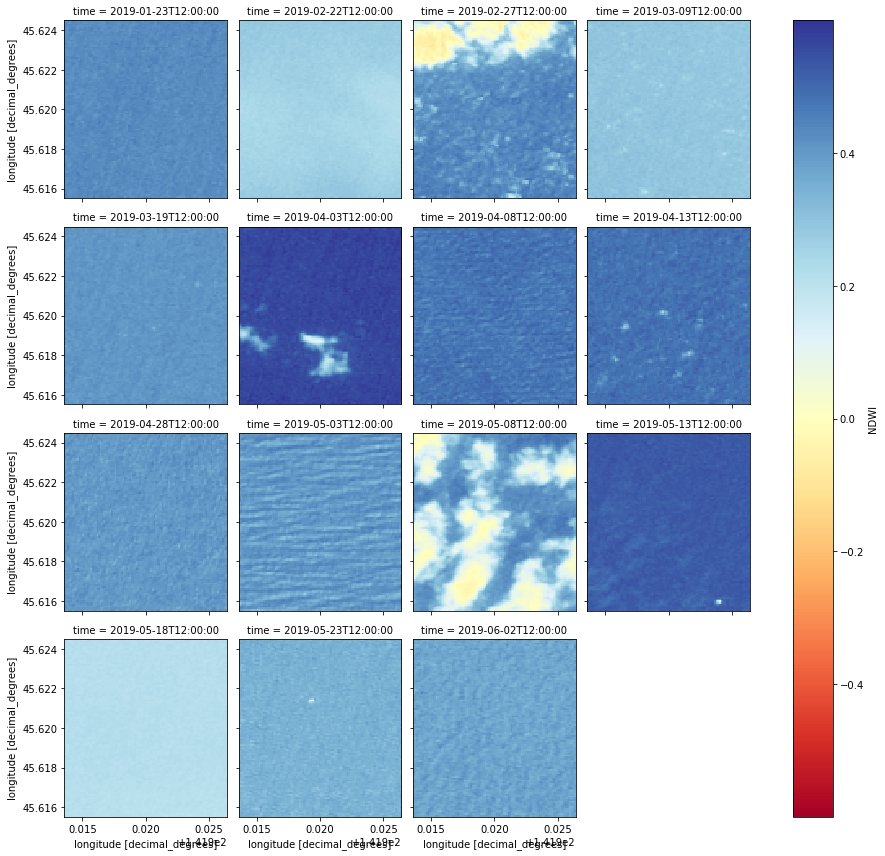

In [215]:
cube, background_ndwi = preprocess(cube, max_cloud_proba=0.2, nans_how='any', verbose=1, plot_NDWI=True)

In [216]:
#cube

In [217]:
#plot_cube_and_background(-cube, background_ndwi, t=11, cmap="RdYlBu") # display results for each band

## 5. Annotate imagery + save results (B03, B08, CLP, bg_NDWI)

In [ ]:
label = input().split(',') # comma value separated
label = [int(l) for l in label]
assert len(label) == len(cube.time)
save_labels(cube, background_ndwi, label, lat_lon=(lat,lon), data_dir=os.path.join(data_dir, 'chips'), label_filename=os.path.join(data_dir, 'labels.json'))